In [1]:
import sys
sys.path.append('/Users/leah/Columbia/courses/19summer/SocialBehavior/SocialBehaviorptc')

In [2]:
from ssm_ptc.models.hmm import HMM
from ssm_ptc.observations.ar_sigmoid_normal_observation import ARSigmoidNormalObservation
from ssm_ptc.distributions.sigmoidnormal import SigmoidNormal
from ssm_ptc.transformations.linear import LinearTransformation
from ssm_ptc.utils import find_permutation, random_rotation, k_step_prediction

import torch
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

from hips.plotting.colormaps import gradient_cmap, white_to_color_cmap
color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

from tqdm import tqdm_notebook as tqdm
import time

In [3]:
import joblib

datasets_processed = joblib.load('/Users/leah/Columbia/courses/19summer/SocialBehavior/tracedata/all_data_3_1')  # a list of length 30, each is a social_dataset

rendered_data = []
for dataset in datasets_processed:
    session_data = dataset.render_trajectories([3,8])  # list of length 2, each item is an array (T, 2). T = 36000
    rendered_data.append(np.concatenate((session_data),axis = 1)) # each item is an array (T, 4)
trajectories = np.concatenate(rendered_data,axis = 0)  # (T*30, 4)

traj29 = rendered_data[29]

In [4]:
arena_xmax = 320
arena_ymax = 370

In [5]:
K = 5
D = 4
T = 36000

bounds = np.array([[-10, arena_xmax + 10], [-10, arena_ymax + 10], [-10, arena_xmax + 10],
                   [-10, arena_ymax + 10]])

#bounds = np.array([[-300, 300], [-300, 300], [-300, 300], [-300, 300]])

In [6]:
data = torch.tensor(traj29, dtype=torch.float64)

mus_init = data[0][None,].repeat(K,1)
sigmas = np.ones((K, D)) * 0.005
train_sigma=False

tran = LinearTransformation(K=K, D=D, lags=1)
observation = ARSigmoidNormalObservation(K=K, D=D, M=0, mus_init=mus_init, sigmas=sigmas, 
                                         transformation=tran, bounds=bounds, alpha=0.5, train_sigma=train_sigma)

model = HMM(K=K, D=D, M=0, observation=observation)



In [7]:
model.log_likelihood(data)

tensor(-1.9198e+13, dtype=torch.float64, grad_fn=<HMMNormalizerCythonBackward>)

In [8]:
num_iters = 3000
pbar = tqdm(total=num_iters, file=sys.stdout)

optimizer = torch.optim.Adam(model.params, lr=0.005)

losses = []
for i in np.arange(num_iters):

    optimizer.zero_grad()

    loss = model.loss(data)
    loss.backward(retain_graph=True)
    optimizer.step()
    losses.append(loss.detach().numpy())
    
    if i % 10 == 0:
        pbar.set_description('iter {} loss {:.2f}'.format(i, loss))
        pbar.update(10)
        
pbar.close()

In [42]:
num_iters = 2000
pbar = tqdm(total=num_iters, file=sys.stdout)

optimizer = torch.optim.Adam(model.params, lr=0.001)

losses = []
for i in np.arange(num_iters):

    optimizer.zero_grad()

    loss = model.loss(data)
    loss.backward(retain_graph=True)
    optimizer.step()
    losses.append(loss.detach().numpy())
    
    if i % 10 == 0:
        pbar.set_description('iter {} loss {:.2f}'.format(i, loss))
        pbar.update(10)
        
pbar.close()

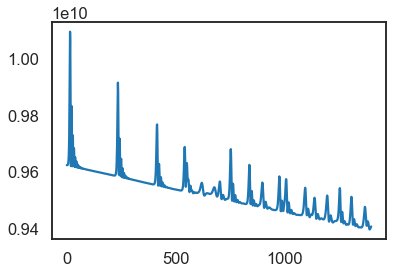

In [9]:
plt.plot(losses[1600:])

# check prediction

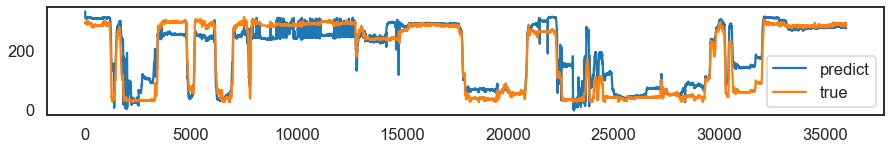

In [10]:
z = model.most_likely_states(data)
x_predict_arr = k_step_prediction(model, z, data)

plt.figure(figsize=(15,2))
plt.plot(x_predict_arr[:,0], label='predict')
plt.plot(data[:,0].numpy(), label='true')
plt.legend()
plt.show()

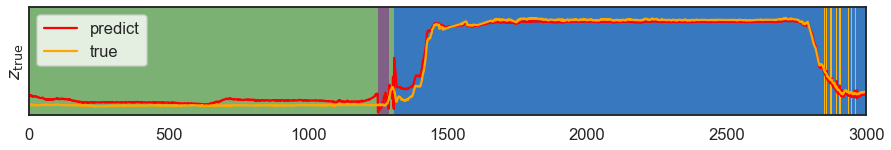

In [94]:
plt.figure(figsize=(15,2))
plt.plot(x_predict_arr[2000:5000,0], label='predict', color='red')
plt.plot(data[2000:5000,0].numpy(), label='true', color='orange')
plt.legend()

lim = 1.05 * 320

#plt.figure(figsize=(15,2))
plt.imshow(z[None,2000:5000], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1, extent=(0, 5000-2000, 0, lim))
plt.xlim(0, 5000-2000)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

plt.show()

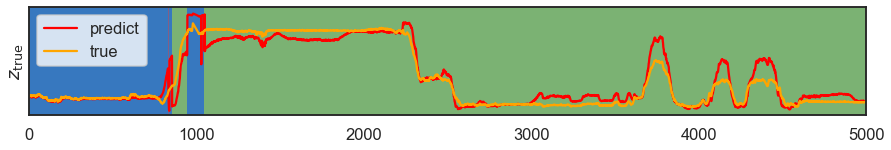

In [106]:
plt.figure(figsize=(15,2))
plt.plot(x_predict_arr[20000:25000,0], label='predict', color='red')
plt.plot(data[20000:25000,0].numpy(), label='true', color='orange')
plt.legend()

lim = 1.05 * 320

#plt.figure(figsize=(15,2))
plt.imshow(z[None,20000:25000], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1, extent=(0, 25000-20000, 0, lim))
plt.xlim(0, 25000-20000)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

plt.show()

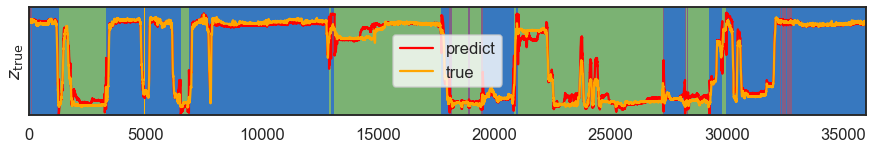

In [108]:
plt.figure(figsize=(15,2))
plt.plot(x_predict_arr[:,0], label='predict', color='red')
plt.plot(data[:,0].numpy(), label='true', color='orange')
plt.legend()

lim = 1.05 * 320

#plt.figure(figsize=(15,2))
plt.imshow(z[None,], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1, extent=(0, T, 0, lim))
plt.xlim(0, T)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

plt.show()

## check samples

In [11]:
center = np.array([arena_xmax/2, arena_ymax/2, arena_xmax/2, arena_ymax/2])[None,]

In [12]:
prefix = (torch.tensor([1], dtype=torch.int), torch.tensor(center, dtype=torch.float64))

In [16]:
sample_z, sample_x = model.sample(10000, prefix=prefix)

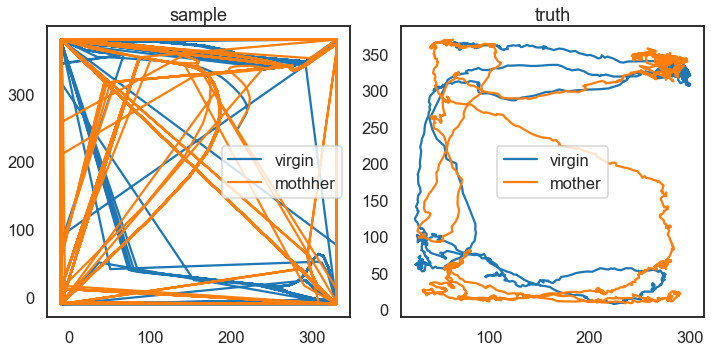

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(sample_x[:,0], sample_x[:,1], label='virgin')
axs[0].plot(sample_x[:,2], sample_x[:, 3], label='mothher')
axs[0].legend()
axs[0].set_title('sample')

axs[1].plot(traj29[:5000,0], traj29[:5000,1], label='virgin')
axs[1].plot(traj29[:5000,2], traj29[:5000,3], label='mother')
axs[1].legend()
axs[1].set_title('truth')

plt.tight_layout()

In [18]:
zs = torch.tensor([4]*1000)

In [19]:
sample_x = model.sample_condition_on_zs(zs, x0=data[0])

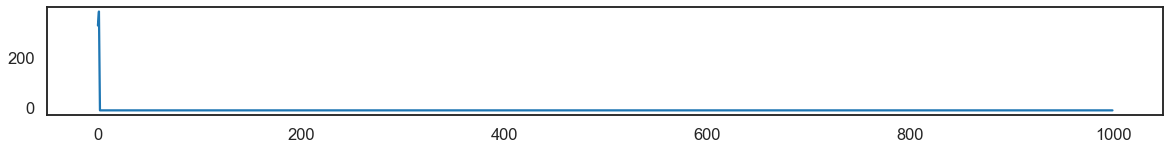

In [20]:
plt.figure(figsize=(20,2))
plt.plot(sample_x[:,1])

In [96]:
sample_z.shape

(1000,)

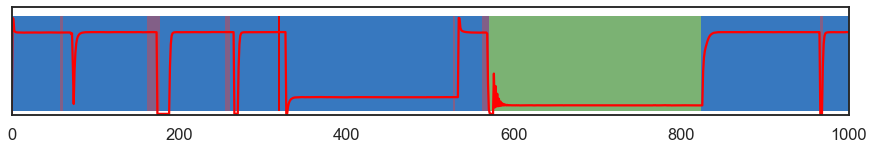

In [105]:
plt.figure(figsize=(15,2))
plt.plot(sample_x[:,0], label='predict', color='red')


lim = 1.05 * 320

#plt.figure(figsize=(15,2))
plt.imshow(sample_z[None,], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1, extent=(-15, 1000, 0, lim))
plt.xlim(0, 1000)

plt.ylim(-15, 370)

plt.yticks([])

plt.show()


## check variance

In [111]:
mus = tran.transform(data)
p_data = SigmoidNormal(mus=mus, log_sigmas=observation.log_sigmas, bounds=bounds, alpha=0.5)

In [112]:
samples = p_data.sample((200,))

In [113]:
mean = torch.mean(samples, dim=0)

In [114]:
d_data = mean.numpy() - data.numpy()[:,None]

In [115]:
std = torch.std(samples, dim=0)

In [116]:
std.shape

torch.Size([36000, 5, 4])

std is not big

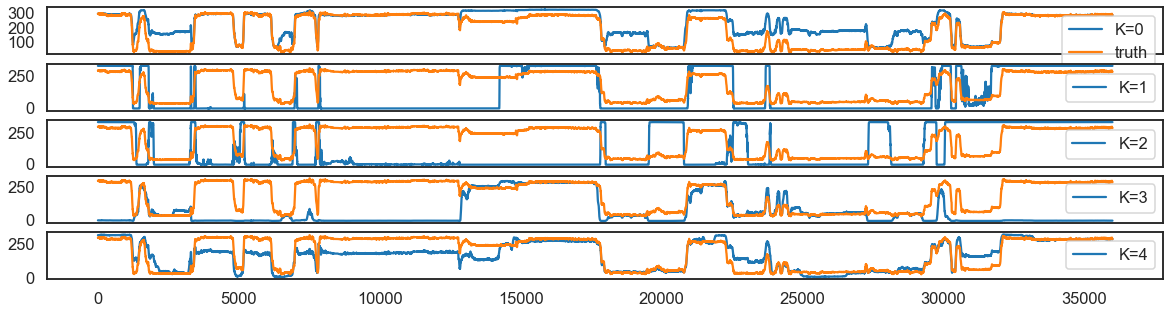

In [186]:
plt.figure(figsize=(20,5))

plt.subplot(5,1,1)
plt.plot(mean[:-1,0,0].numpy(), label='K=0')
#plt.plot(mean[:-1,1,0].numpy(), label='pred1')
#plt.plot(mean[:-1,2,0].numpy(), label='pred2')
#plt.plot(mean[:-1,3,0].numpy(), label='pred3')
#plt.plot(mean[:-1,4,0].numpy(), label='pred4')
plt.plot(traj29[1:,0], label='truth')
plt.legend()

plt.subplot(5,1,2)
plt.plot(mean[:-1,1,0].numpy(), label='K=1')
plt.plot(traj29[1:,0])
plt.legend()

plt.subplot(5,1,3)
plt.plot(mean[:-1,2,0].numpy(), label='K=2')
plt.plot(traj29[1:,0])
plt.legend()

plt.subplot(5,1,4)
plt.plot(mean[:-1,3,0].numpy(), label='K=3')
plt.plot(traj29[1:,0])
plt.legend()

plt.subplot(5,1,5)
plt.plot(mean[:-1,4,0].numpy(), label='K=4')
plt.plot(traj29[1:,0])
plt.legend()

Text(0.5, 1, 'true trajectory clip')

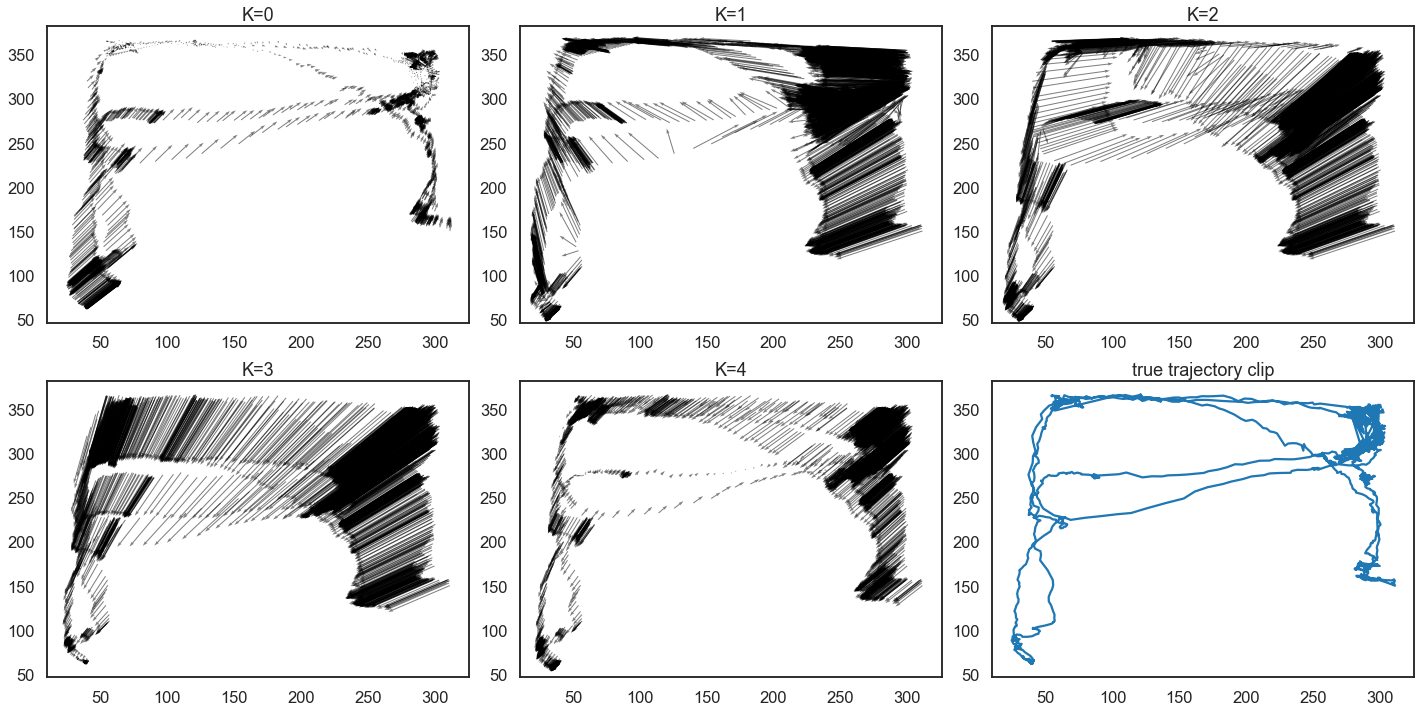

In [149]:
plot_quiver(data[5000:10000], d_data[5000:10000], 'virgin')
plt.plot(traj29[5000:10000,0], traj29[5000:10000,1])
plt.title('true trajectory clip')

Text(0.5, 1, 'true trajectory clip')

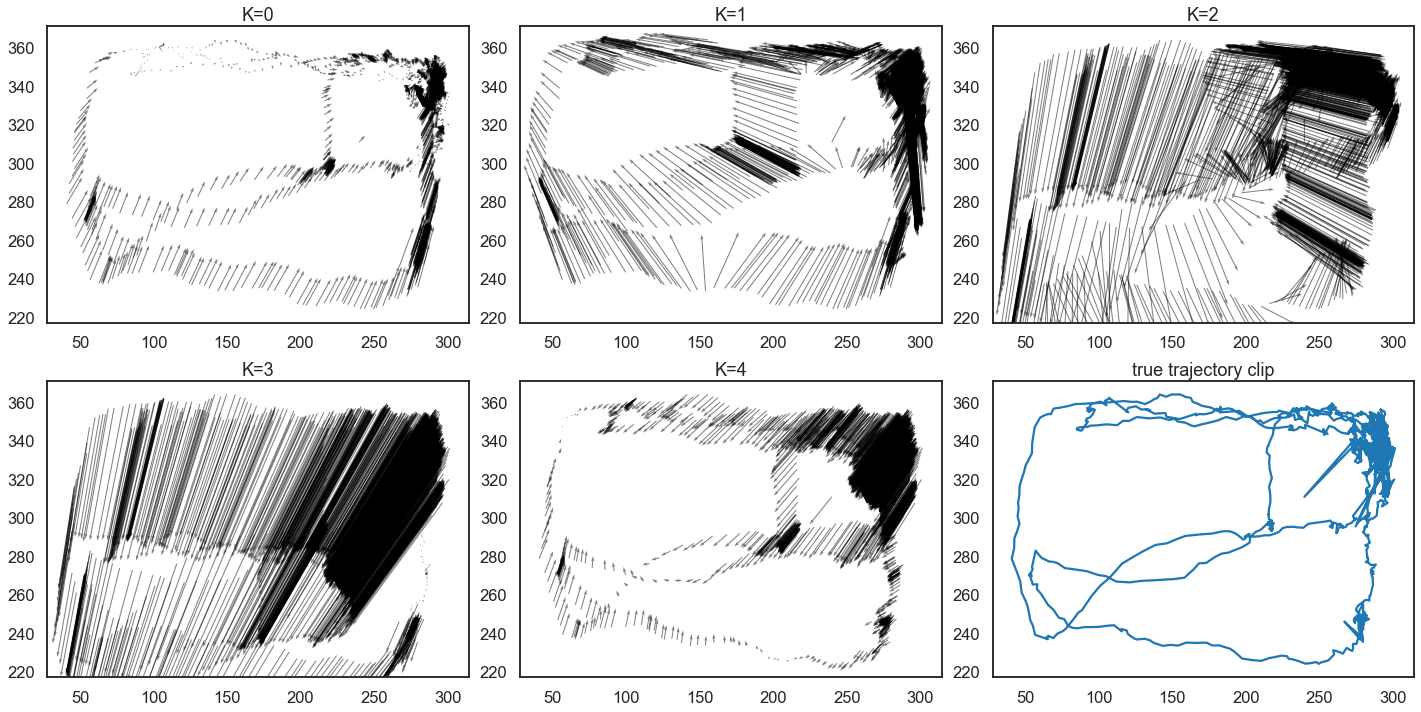

In [150]:
plot_quiver(data[5000:10000], d_data[5000:10000], 'mother')
plt.plot(traj29[5000:10000,2], traj29[5000:10000,3])
plt.title('true trajectory clip')

In [142]:
[sum(z==k) for k in range(K)]

[19461, 1, 34, 15676, 828]

In [139]:
def plot_quiver(XYs, dXYs, mouse, other_mouse_loc=None):
    if mouse == 'virgin':
        i = 0
        j = 1
    elif mouse == 'mother':
        i = 2
        j = 3
        
    fig, axs = plt.subplots(2, 3, figsize=(20, 10))

    axs[0][0].quiver(XYs[:,i], XYs[:,j], dXYs[:, 0, i], dXYs[:, 0, j],
                           angles='xy', scale_units='xy', scale=5, alpha=0.5)
    axs[0][0].set_title('K=0')

    axs[0][1].quiver(XYs[:,i], XYs[:,j], dXYs[:, 1, i], dXYs[:, 1, j],
                           angles='xy', scale_units='xy', scale=5, alpha=0.5)
    axs[0][1].set_title('K=1')

    axs[0][2].quiver(XYs[:,i], XYs[:,j], dXYs[:, 2, i], dXYs[:, 2, j],
                           angles='xy', scale_units='xy', scale=5, alpha=0.5)
    axs[0][2].set_title('K=2')

    axs[1][0].quiver(XYs[:,i], XYs[:,j], dXYs[:, 3, i], dXYs[:, 3, j],
                           angles='xy', scale_units='xy', scale=5, alpha=0.5)
    axs[1][0].set_title('K=3')
    
    axs[1][1].quiver(XYs[:,i], XYs[:,j], dXYs[:, 4, i], dXYs[:, 4, j],
                           angles='xy', scale_units='xy', scale=5, alpha=0.5)
    axs[1][1].set_title('K=4')
    
    if other_mouse_loc is not None:
        axs[0][0].plot(*other_mouse_loc, 'ro')
        axs[0][1].plot(*other_mouse_loc, 'ro')
        axs[0][2].plot(*other_mouse_loc, 'ro')
        axs[1][0].plot(*other_mouse_loc, 'ro')
        axs[1][1].plot(*other_mouse_loc, 'ro')
    """
    for row_axs in axs:
        for ax in row_axs:
            ax.set_xlim([0, 330])
            ax.set_ylim([0, 380])
    """
    plt.tight_layout()

In [151]:
mean.shape

torch.Size([36000, 5, 4])

In [152]:
z.shape

(36000,)

In [157]:
z[2]

0

In [158]:
selected_mean = torch.empty(36000, 4, dtype=torch.float64)
for i in range(36000):
    selected_mean[i] = mean[i][z[i]]

'\nlim = 1.05 * 320\n\n#plt.figure(figsize=(15,2))\nplt.imshow(z[None,], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1, extent=(0, T, 0, lim))\nplt.xlim(0, T)\nplt.ylabel("$z_{\\mathrm{true}}$")\nplt.yticks([])\n\n'

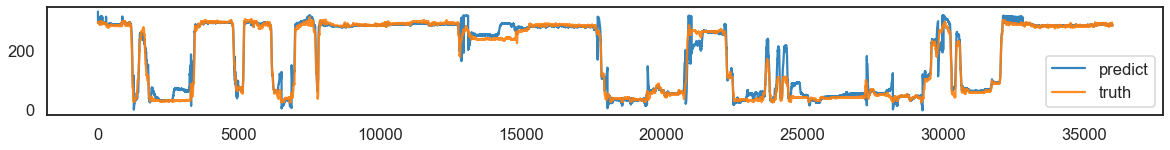

In [169]:
plt.figure(figsize=(20,2))
plt.plot(selected_mean[:,0].numpy(), label='predict', alpha=0.9)
plt.plot(traj29[:,0], label='truth', alpha=0.9)
plt.legend()

"""
lim = 1.05 * 320

#plt.figure(figsize=(15,2))
plt.imshow(z[None,], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1, extent=(0, T, 0, lim))
plt.xlim(0, T)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

"""

In [168]:
[sum(z == k) for k in range(K)]

[19461, 1, 34, 15676, 828]

In [187]:
nest = np.array([270, 330])

In [188]:
XX, YY = np.meshgrid(np.linspace(0, 320, 10), 
                     np.linspace(0, 370, 10))
XY = np.column_stack((np.ravel(XX), np.ravel(YY))) # shape (100,2) grid values

XY_other = np.tile(nest[None,], (100,1))

XY_virgin = np.concatenate((XY, XY_other), axis=1)
XY_mother = np.concatenate((XY_other, XY), axis=1)

mus_virgin = tran.transform(torch.tensor(XY_virgin, dtype=torch.float64))
p_virgin = SigmoidNormal(mus=mus_virgin, log_sigmas=observation.log_sigmas, bounds=bounds, alpha=0.5)

mus_mother = tran.transform(torch.tensor(XY_mother, dtype=torch.float64))
p_mother = SigmoidNormal(mus=mus_mother, log_sigmas=observation.log_sigmas, bounds=bounds, alpha=0.5)

samples_virgin = p_virgin.sample((10000,))
samples_mother = p_mother.sample((10000,))

dXY_virgin = torch.mean(samples_virgin, dim=0).numpy() - XY_virgin[:, None]
dXY_mother = torch.mean(samples_mother, dim=0).numpy() - XY_mother[:, None]

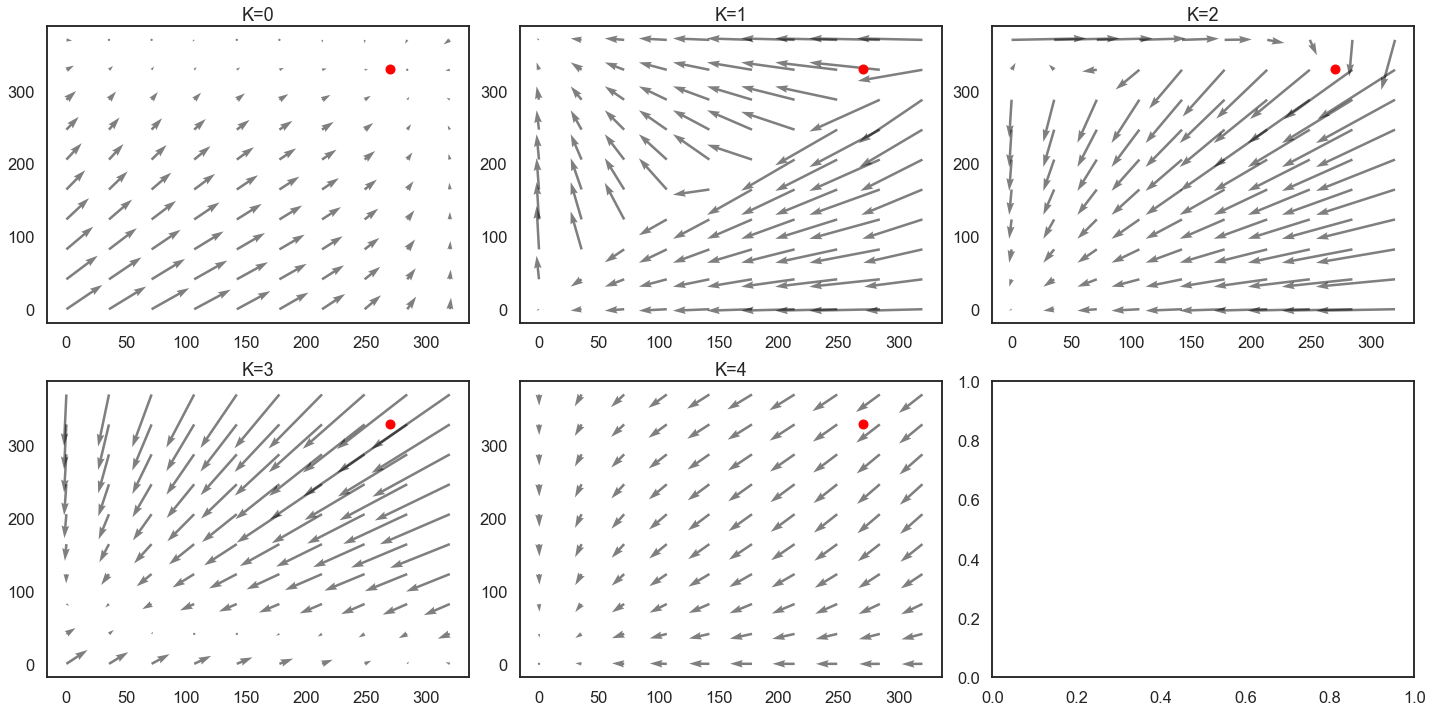

In [189]:
plot_quiver(XY_virgin, dXY_virgin, 'virgin', nest)

In [193]:
[sum(z==k) for k in range(K)]

[19461, 1, 34, 15676, 828]